# 최초 1회 실행

In [1]:
# print('### OS ###')
# !cat /etc/issue.net

# print('### CPU ###')
# !cat /proc/cpuinfo

# print('### MEM ###')
# !cat /proc/meminfo

# print('### DISK ###')
# !df -h

# print('### GPU ###')
# !nvidia-smi


!pip uninstall -y tensorflow
!pip install tensorflow==1.15

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 412.3MB 22kB/s 
     |████████████████████████████████| 3.8MB 37.4MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 512kB 28.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=17c46b566de7827948f52df2dc4b6658d6bfdaa15178a705cc2ba28652d8de6c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    U

In [2]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

  Created wheel for colabgymrender: filename=colabgymrender-1.0.8-cp37-none-any.whl size=2511 sha256=ba2a1f3a691f84a47c6ddaadc9f2342e2ab71e8bb44ca6aa8697180f3f9bf3cc
  Stored in directory: /root/.cache/pip/wheels/8a/d1/e8/ef1d4f6e536cc6b965b28c859ccd2a7f7ab123b94ef4007712
Successfully built colabgymrender


# 초기 설정
* 환경 만들기  
* 텐서플로우1 설정  
* colab에서의 OpenAI 비디오 렌더링

In [2]:
import tensorflow as tf
print(tf.__version__)

import torch
import torchvision
import torchtext
print(torch.__version__)

1.15.0
1.8.0+cu101


In [3]:
# 초기 설정 (텐서플로우1 사용, colab 렌더링 포함)
import tensorflow as tf
# import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import gym
env = gym.make('CartPole-v1')
env._max_episode_steps = 10001

# from colabgymrender.recorder import Recorder
# directory = './video'
# env = Recorder(env, directory)

REWARD = -100
MAX_EPI = 2000
H_SIZE = 10
L_RATE = 1e-1

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

dis = 0.9
REPLAY_MEMORY = 50000
results = []

# 네트워크

In [4]:
class DQN:
  def __init__(self, session, input_size, output_size, name="main"):
    self.session = session
    self.input_size = input_size
    self.output_size = output_size
    self.net_name = name
    self._build_network()

  def _build_network(self, h_size=H_SIZE, l_rate=L_RATE):
    with tf.variable_scope(self.net_name):
      self._X = tf.placeholder(tf.float32, [None, self.input_size], 
                               name="input_x")

      # weights의 첫 레이어
      W1 = tf.get_variable("W1", shape=[self.input_size, h_size], 
                           initializer=tf.contrib.layers.xavier_initializer())
      layer1 = tf.nn.tanh(tf.matmul(self._X, W1))

      # 두 번째 레이어
      W2 = tf.get_variable("W2", shape=[h_size, self.output_size],
                           initializer=tf.contrib.layers.xavier_initializer())

      # Q 예측
      self._Qpred = tf.matmul(layer1, W2)

    # a로 훈련하는 네트워크를 정의해야 한다.
    # policy
    self._Y = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)

    # loss function
    self._loss = tf.reduce_mean(tf.square(self._Y - self._Qpred))
    
    # 훈련
    self._train = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(self._loss)

  def predict(self, state):
    x = np.reshape(state, [1, self.input_size])
    return self.session.run(self._Qpred, feed_dict={self._X: x})
  
  def update(self, x_stack, y_stack):
    return self.session.run([self._loss, self._train], 
                            feed_dict={self._X: x_stack, self._Y: y_stack})

# Replay buffer로 훈련

In [5]:
# train_batch로 단순하게 훈련
def simple_replay_train(DQN, train_batch):
  x_stack = np.empty(0).reshape(0, DQN.input_size)
  y_stack = np.empty(0).reshape(0, DQN.output_size)

  # 버퍼에 저장된 정보를 가져온다
  for state, action, reward, next_state, done in train_batch:
    Q = DQN.predict(state)

    # 종료 확인
    if done:
      Q[0, action] = reward
    else:
      Q[0, action] = reward + dis * np.max(DQN.predict(next_state))
    
    y_stack = np.vstack([y_stack, Q])
    x_stack = np.vstack([x_stack, state])

  return DQN.update(x_stack, y_stack)

# bot play

In [6]:
def bot_play(mainDQN):
  # 우리의 훈련된 네트워크의 액션을 본다
  s = env.reset()
  reward_sum = 0
  while True:
    # env.render()
    a = np.argmax(mainDQN.predict(s))
    s, reward, done, _ = env.step(a)
    reward_sum += reward

    if done:
      print("Total score: {}".format(reward_sum))
      # env.play()
      break
  
  

# main

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Episode: 0 steps: 54
Episode: 1 steps: 42
Loss:  2.1037045
Episode: 2 steps: 20
Episode: 3 steps: 54
Episode: 4 steps: 28
Episode: 5 steps: 11
Episode: 6 steps: 35
Episode: 7 steps: 30
Episode: 8 steps: 59
Episode: 9 steps: 61
Episode: 10 steps: 77
Episode: 11 steps: 56
Loss:  8.231886
Episode: 12 steps: 15
Episode: 13 steps: 11
Episode: 14 steps: 9
Episode: 15 steps: 10
Episode: 16 steps: 8
Episode: 17 steps: 10
Episode: 18 steps: 8
Episode: 19 steps: 12
Episode: 20 steps: 9
Episode: 21 steps: 11
Loss:  389.33194
Episode: 22 steps: 10
Episode: 23 steps: 11
Episode: 24 steps: 13
Episode: 25 steps: 10
Episode: 26 steps: 11
Episod

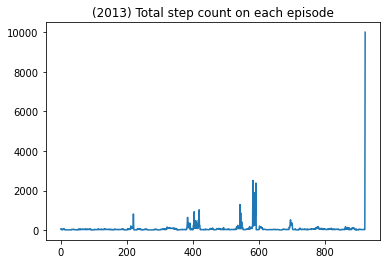

In [7]:
def main():
  max_episodes = MAX_EPI

  # 이전 관찰을 replay memory에 저장한다.
  replay_buffer = deque()
  
  with tf.Session() as sess:
    mainDQN = DQN(sess, input_size, output_size)
    tf.global_variables_initializer().run()

    for episode in range(max_episodes):
      e = 1. / ((episode / 10) + 1)
      done = False
      step_count = 0

      state = env.reset()

      while not done:
        # e-greedy 방식으로 action 선택
        if np.random.rand(1) < e:
          action = env.action_space.sample()
        else:
          action = np.argmax(mainDQN.predict(state))

        # 환경에서 새 상태와 보상을 얻는다.
        next_state, reward, done, _ = env.step(action)
        
        # 패널티
        if done:
          reward = REWARD

        # 버퍼에 관찰 결과를 저장한다.
        replay_buffer.append((state, action, reward, next_state, done))
        if len(replay_buffer) > REPLAY_MEMORY:
          replay_buffer.popleft()
        
        state = next_state
        step_count += 1
        if step_count > 10000:
          break

      print("Episode: {} steps: {}".format(episode, step_count))
      results.append(step_count)

      if step_count > 10000:
          break
          
      # 10번마다 훈련한다.
      if episode % 10 == 1:
        # 버퍼에서 랜덤 배치를 얻는다.
        for _ in range(50):
          minibatch = random.sample(replay_buffer, 10)
          loss, _ = simple_replay_train(mainDQN, minibatch)
        print("Loss: ", loss)
    bot_play(mainDQN)
    plt.title("(2013) Total step count on each episode")
    plt.plot(range(len(results)), results)
    plt.show()

main()
